# **Assignment 2**

#### **MSc** Scientific and Data Intensive Computing,
#### University College London, 2021-2022

#### Techniques of High Performance Computing (PHAS0102)

###**Cong Zheng** 
### **Student ID: 21055428**

## Table of Contents
#### 1. Introduction
#### 2. Task1:Solution to the Discrete Poisson Problem Based on CPU
#####    2.1 Compilation of related functions
#####    2.2 Solving test
#####    2.3 Benchmarking
#####    2.4  Convergence analysis based on the largest relative difference
#####    2.5 Summary
#### 3. Task2: GPU acceleration solution based on CUDA architecture
#####    3.1 CPU-based iterative solution scheme
#####    3.2 Overview of CUDA
#####    3.3 CUDA-based solution
#####    3.4 Convergence between iterations from kth to k+1th
#####    3.5 GPU benchmark
#####    3.6 GPU convergence analysis
#####    3.7 Optimize memory access
#####    3.8 Summary

#### 4. Conclusion
#### 5. Reference



## 1. Introduction

Partial differential equations are of great significance to modern engineering. Among them, the method of solving partial differential equations can be divided into numerical method and analytical method. Among them, analytical methods include variable separation method, characteristic line method and so on. Among the many numerical methods for solving partial differential equations, the three most widely used methods are Finite Element Method, Finite Volume Method and Finite Difference Method. In the actual numerical calculation of partial differential equations, the dimensions of the matrix may range from one million to tens of billions. When matrix operations are used, the matrix used to solve the partial differential equation is often highly sparse. Therefore, according to its sparse nature, it has room for optimization.

In actual production scenarios, the appearance of GPU provides the possibility for numerical fitting to approximate the solution of partial differential equations. Among them, the CUDA architecture has caused a large number of researches by industry professionals and scholars due to its advantages of high concurrency and high computing performance. In 2006, NVIDIA proposed the CUDA architecture. CUDA is a general-purpose parallel computing platform and programming model built on NVIDIA's CPUs. Based on CUDA programming, the parallel computing engine of GPUs can be used to solve more complex computing problems more efficiently. In short, the CUDA programming model provides an abstraction of the GPU architecture. 




In this coursework, the mathematical scenario based on the Poisson problem on the unit square is solved with CPU and GPU respectively. In task1, first, a function for generating sparse matrices A and b is designed by myself. After that, we further compared the numerical solution with the solution generated by the analytical method (that is, the most accurate solution), and observed its convergence characteristics as the dimension of the matrix increases. In task2, in order to further analyze the high performance of GPU in parallel computing, we first used the CPU to complete the iterative solution method. After that, based on the CUDA architecture in Conda, we designed an iterative solution method based on GPU, and further analyzed and discussed its convergence performance with increasing iteration and convergence with increasing N. In addition, it also analyzes the iterative efficiency of the CPU. Finally, the optimized access to the memory is solved by shared memory, and CUDA is further optimized from the perspective of block division and so on.

## 2. Task 1:The solution to the discrete Poisson problem based on CPU

First of all, for the partial differential equation problem in unit square, a solution based on Poisson's method and Laplace operator was designed by us.

Specifically, we implemented a Python callable function discretise, which returns the coefficient matrix A and the result matrix F by calculating only the interior points. After solving the linear matrix of A and F, the numerical solution U of the partial differential equation can be obtained.

### 2.1 Compilation of related functions

First, introduce various header files and packages.

In [9]:
import numpy as np
from scipy.sparse import coo_matrix
from sympy import *
from numba import cuda

%matplotlib inline

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.sparse.linalg import spsolve

According to the requirements of the topic, if you want to request the solution of the partial differential equation, you can rewrite the original equation into a form of the form Ax=b. Therefore, we first need to generate matrix A and matrix b.

In the solution program given in the course, the traversal calculation starts from the boundary point. Assuming that the dimension of the solution matrix x is [N * N], it is easy to get the dimension of the sparse matrix A required to solve the partial differential equation is [N ^2 * N^2], and the dimension of the b matrix on the right hand side is [1 * N^2].

In my newly written function discretise(f,g,N), we have implemented a numerical solution method based on traversing all interior points. Therefore, the function finally returns a matrix A with dimensions [(N-2)^2, (N-2)^2] and a matrix F with dimensions [1, (N-2)^2].

It is worth mentioning that in the function discretise(f,g,N), I did not use the nine if-else notation, but used interior point traversal, and realized the size matrix mapping (from [N * N] mapping To [N-2 * N-2]). Although there is no breakthrough in the complexity of the algorithm, this algorithm is more concise and simple to understand in the program.

In [11]:
def discretise(f, g, N):
    """Generate the matrix and rhs associated with the discrete Poisson operator."""
    
    # The number of non-zero points in the A matrix
    nelements = 5 * N**2 - 24 * N + 28

    # Use the coo method to initialize the A matrix, the size of the A matrix is [(N-2)^2 * (N-2)^2]    
    row_ind = np.empty(nelements, dtype=np.float64)
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    
    # Initialize the F matrix, the size of the F matrix is [1, (N-2)^2]
    F = np.empty((N-2) * (N-2), dtype=np.float64)
    
    count = 0
    for j in range(1, N - 1):
        for i in range(1, N - 1):
            p = j * N + i
            # It is worth noting that p represents the corresponding sequence number of the point in the original matrix A of size N^2*N^2.
            # p//N represents the number of rows of the point in the original matrix, and (p//N-1) represents the point corresponding to the new matrix A of size (N-2)^2*(N-2)^2 Number of rows
            # p%N represents the number of columns of the point in the original matrix, and (p%N-1) represents the corresponding column of the point in the new matrix A of size (N-2)^2*(N-2)^2 number
            # (p//N-1)*(N-2)+(p%N-1) represents the sequence number of the point in the new matrix A of size (N-2)^2*(N-2)^2

            row_ind[count] = (p//N - 1)*(N-2)+(p%N - 1)
            col_ind[count] = (p//N - 1)*(N-2)+(p%N - 1)
            data[count] = 4
            count += 1
            # Assignment of diagonal elements of A matrix -4

            F[(p//N - 1)*(N-2)+(p%N - 1)] = f[p//N,p%N] / (( N + 1)**2)
            # For this row, store the first item of the F matrix h^2*f(i,j)

            Points = [p - 1 , p + 1, p - N, p + N]
            # Next test the four neighbors of each point
            # If the neighboring point is a boundary point, add g(Point[n],Point[n]) to the F element corresponding to the point
            # If the neighboring point is not a boundary point, assign a value of -1 in the A matrix corresponding to the point
            for n in range(4):
                if Points[n]%N == 0 or Points[n]%N == N - 1 or Points[n]//N == 0 or Points[n]//N == N - 1:
                    F[(p//N - 1)*(N-2)+(p%N - 1)] += g[Points[n]//N, Points[n]%N]
                else:
                    row_ind[count] = (p//N - 1)*(N-2)+(p%N - 1)
                    col_ind[count] = (Points[n]//N - 1)*(N-2)+(Points[n]%N - 1)
                    data[count] = -1

                    count += 1     
                                                
    return coo_matrix((data, (row_ind, col_ind)), shape=((N-2)**2, (N-2)**2)).tocsr(), F

In addition, in order to calculate the specific value of the F matrix in the function, we also need to numerically solve the Laplacian f(x,y) of u(x,y) and the boundary condition g(x,y). The functions for solving their specific values are shown below.

In [12]:
def Fexact(x, y):
    # This function is used to calculate the Laplacian corresponding to U(x,y), namely f(x,y)
    uxx = (4*x**2 - 4*x +3)* np.exp((x-0.5)**2+(y-0.5)**2)
    uyy = (4*y**2 - 4*y +3)* np.exp((x-0.5)**2+(y-0.5)**2)
    f = -(uxx + uyy)
    return f

In [13]:
def Gexact(x, y):
    # This function is used to calculate Uexact. When [x,y] is at the boundary, its value is equal to g(x,y)
    uexact = np.exp((x-0.5)**2+(y-0.5)**2)
    return uexact

Based on the above considerations, we can now start to solve the discrete Poisson problem in unit space.

In the function findU(N), we first use the discretise function to generate matrix A with sizes [(N-2)^2, (N-2)^2] and [1, (N-2)^2] And matrix F. After that, we use the spsolve command to solve the linear equations, and convert the solution sol with the size [1, (N-2)^2] to the matrix u of [N-2, N-2].

It is worth mentioning that u is not the final result. Because the discretise function only calculates the interior points and not the boundary points, we also add a circle of boundaries to the matrix u. Finally, the numerical solution U and the theoretical solution g are returned.

In [14]:
def findU(N):
# This function is used to return the solutions U and g of Ax=b when the size is N

    U = np.empty([N, N], dtype=np.float64)

    ticks= np.linspace(0, 1, N)
    X, Y = np.meshgrid(ticks, ticks)

    f = Fexact(X, Y)
    g = Gexact(X, Y)

    A, F = discretise(f, g, N)

    sol = spsolve(A, F)
    u = sol.reshape((N-2, N-2))

    for j in range(N):
        for i in range(N):
            p = j * N + i
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                U[i, j] = g[i ,j]
            else:
                U[i, j] = u[i-1, j-1]

    return U, g

In order to show the solution U obtained by our self-created discretise function more clearly and intuitively, we designed the plot_U function to draw a specific three-dimensional image of U on the identity matrix. In addition, we also projected contour lines on the x-y plane for the image.

In [15]:
def plot_U(X, Y, U, t):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.gca(projection='3d')

    # make the panes transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

    surf = ax.plot_surface(X, Y, g, alpha=0.7, antialiased=False, cmap=cm.rainbow)
    ax.contour(X,Y,g, zdir='z', offset=1,cmap=cm.winter) 

    ax.set_xlabel('X')
    ax.set_xlim(0, 1) 
    ax.set_ylabel('Y')
    ax.set_ylim(0, 1)
    ax.set_zlabel('U[X, Y]')
    ax.set_zlim(1, 1.8)

    plt.title(t)
    plt.show()


### 2.2 Solving test

Based on the above considerations, we can now begin to solve the discrete Poisson problem in unit space.

First, we set U(x,y) as a matrix of size N*N, and N=160, and set the domains X and Y to be within the range of [0,1] (that is, unit square).

In order to verify the correctness of the interior point solution method I wrote, we calculated the numerical solution U and the analytical solution Uexact respectively, and compared them. First, we first use the findU function to generate the matrices A and F and then solve and get the numerical solution U. Next, since the analytical solution Uexact in this mathematical scenario is known, we directly calculated Uexact.

In [16]:
# Set U(x,y) as a matrix of size N*N
N = 160

# Set the domain X and Y to be in the range of [0,1]
ticks = np.linspace(0, 1, N)
X, Y = np.meshgrid(ticks, ticks)

# Calculate the numerical solution U and the analytical solution g
U = findU(N)
g = Gexact(X, Y)

Next, in order to show the numerical solution X and the theoretical solution Uexact clearly and intuitively, we used the drawing function to draw their three-dimensional images on the unit square.

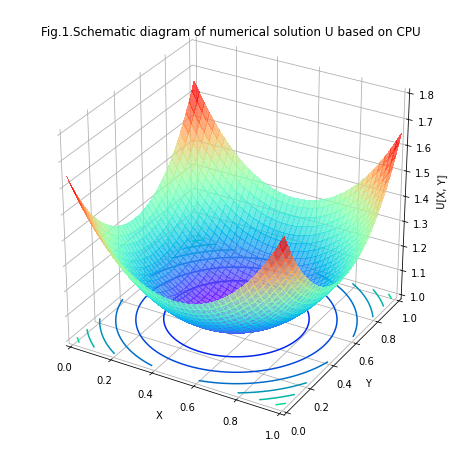

In [17]:
plot_U(X, Y, U, 'Fig.1.Schematic diagram of numerical solution U based on CPU')

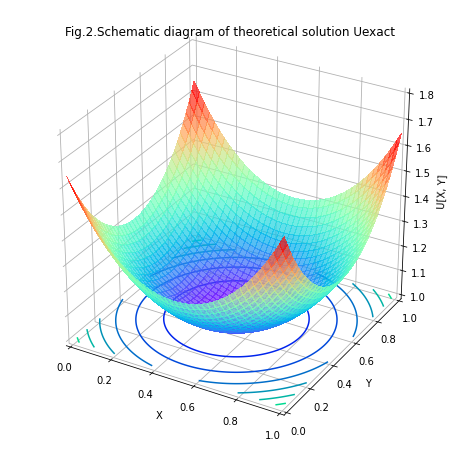

In [18]:
plot_U(X, Y, g, 'Fig.2.Schematic diagram of theoretical solution Uexact')

Observing Fig. 1 and Fig. 2, it is not difficult to find that for a matrix with a matrix size N of 160, within the unit square range, the numerical solution U and the theoretical solution Uexact obtained by our calculations show almost the same change trend, both of which are in the shape of a paraboloid of revolution. . Since the two are exactly the same shape, it is not difficult for us to prove that the discretise method can basically correctly approximate the numerical solution on the unit square.

### 2.3 Benchmarking

In order to explore the optimization space of the solution in terms of time, and to compare with the subsequent CUDA parallel computing performance, we benchmarked the solution.

Specifically, we selected five matrix sizes N in the range of 100-1000, and respectively calculated the time-consuming situation of the findU function we designed under different matrix dimensions N.

In [ ]:
timeit_result1 = np.zeros(5, dtype=np.float64)

for loop in range(100,1000,200):
    timeit_result_1 = %timeit -o findU(loop)
    timeit_result1[int(loop//200)] = timeit_result_1.best

In order to show more intuitively and concretely as the matrix dimension N increases, the time consumed by the findU function, we also draw the time-consuming image, as shown in the figure3.

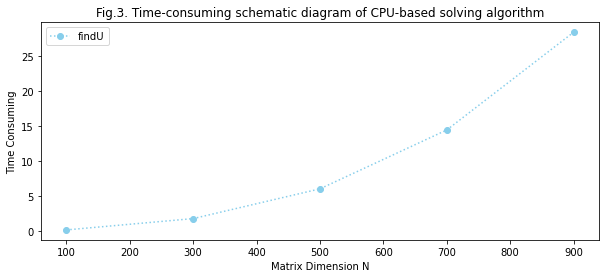

In [21]:
x_fit = range(100, 1000, 200)

plt.figure(figsize=(10,4))
plt.plot(x_fit,timeit_result1, ':',label = 'findU',color='skyblue', marker = 'o')

plt.xlabel('Matrix Dimension N')
plt.ylabel('Time Consuming')
plt.title('Fig.3. Time-consuming schematic diagram of CPU-based solving algorithm')
plt.legend()
plt.show()

Observing Figure 3, it is not difficult to find that with the increase of the matrix dimension N, the time-consuming of the findU function shows an exponential growth trend. For example, when the matrix dimension N is 500, it takes 4.85 seconds, and when the matrix dimension N increases to 900, the time consumption of the findU function increases to 21.5s, which reflects a strong time-consuming growth trend.

There are three main reasons why this function exhibits unsatisfactory time performance.

First of all, the matrix dimension N is too large, which means that a large number of logically unrelated calculations, such calculations can be completely parallel. From a hardware point of view, this function is based on the CPU. The CPU is suitable for algorithmic calculations with complex logic and less calculation, and GPU has better parallel computing performance.

In addition, when the space occupied by the matrix dimension N increases to exceed the L1 cache, since the matrix cannot be fully loaded into the cache, more cache misses will be missed, causing a lot of time to be consumed in memory read and write operations.

In addition, in order to highlight the excellent performance of GPU in the following article, the findU function does not even use numpy's jit optimization, which also leads to the possibility of using GPU for optimization of this function.

### 2.4 Convergence analysis based on the largest relative difference

Next, we analyze the convergence of the algorithm.

When the matrix dimension N increases, in order to further discuss the convergence of the obtained numerical solution U relative to the theoretical solution Uexact, we select 8 matrices in the range of the matrix dimension N from 100 to 900. For each matrix of size N, we have calculated its maximum relative error with respect to the theoretical solution of size N.

In [22]:
maxerels = np.empty(8, dtype=np.float64)
count = 0

for n in range(100,900,100):

    U1,g1 = findU(n)

    maxeral = 0  
    for i in range(n):
        for j in range(n):
            eral = abs(U1[i,j] - g1[i,j])/abs(g1[i,j])
            if eral > maxeral:
                maxeral = eral
            else:
                continue
                    
    maxerels[count] = maxeral
    count += 1

In addition, in order to show the convergence more intuitively and concretely, we also used the loglog command to plot the change trend of the corresponding maximum relative error as the matrix dimension N increases. As shown in Figure 4.

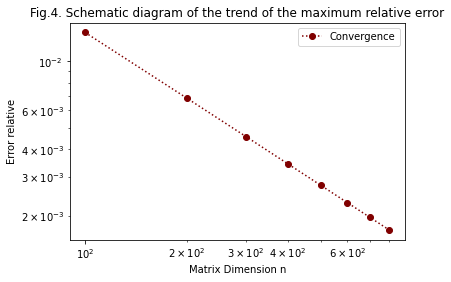

In [23]:
plt.loglog(range(100,900,100),maxerels,
           ':',label = 'Convergence', color='maroon', marker = 'o')

ax = plt.gca()
ax.set_facecolor('w')

plt.xlabel('Matrix Dimension n')
plt.ylabel('Error relative')
plt.title('Fig.4. Schematic diagram of the trend of the maximum relative error')
plt.legend()
plt.show()  

Observing Figure 4 is easy to get, as the matrix dimension N increases, this function shows excellent convergence. Specifically, when N is 100, the maximum relative error is about 0.0135205267 (level 10^-2), and when the size of N is 800, the maximum relative error is reduced to 0.0017182 (level 10^-3). An error reduction of the order of 10 to the 1st power.

Figure 4 shows the excellent convergence properties of the function as N increases. But at the same time, we also found that when N increases, its convergence performance has an upper limit of optimization, because when N is extremely large, the numerical solution U is already very close to the theoretical solution Uexact, which also means an extremely limited optimization space.

### 2.5 Summary

In Task1, we implemented a CPU-based discrete Poisson partial differential equation solution. This scheme is based on the idea of interior point traversal, and finally a numerical solution is solved. As the matrix dimension N increases, the time-consuming of the solution increases exponentially, but at the same time, the numerical solution is getting closer and closer to the analytical solution, showing excellent convergence performance.

Regarding the convergence speed, it is not difficult to find that the sparse matrix storage method in the CPU optimizes the occupied space and the data has high storage accuracy, resulting in a faster convergence speed. In a highly parallel GPU, although its running speed is faster, low-precision storage will cause its optimization space to have an upper limit, and the iteration speed is slow.

Due to the high number of calculations of the algorithm and the high degree of concurrency of calculation operations, the algorithm has room for optimization by the GPU architecture.

## 3. Task 2: GPU acceleration solution based on CUDA architecture

In Task1, we implemented a solution to the discrete Poisson partial differential equation in the unit square in the CPU. Although it effectively obtains a numerical solution and shows good convergence, the disadvantage is that it takes too long.

In order to reflect the excellent parallel computing performance of the GPU, in Task2, based on the CUDA architecture in Numba, we implemented an iterative scheme on the GPU to solve the original Poisson equation.

### 3.1 CPU-based iterative solution scheme

Before the GPU iterative programming, in order to better compare the computing performance difference between CPU and GPU, we first completed a CPU-based iterative solution scheme.Specifically, the discretise_cpu function is based on the idea of iterative solution. According to the input f (x, y) and g (x, y), K iterations are performed on the matrix with the size of N, and finally the value after the K iteration is returned. Solve the U matrix.

In [24]:
def discretise_cpu(f, g, N, K):
# Open up two matrices of size N*N to update the iteration results in turn
    U1 = np.zeros([N, N], dtype=np.float64)
    U2 = np.zeros([N, N], dtype=np.float64)
    # First assign g[i,j] to the boundary of U1 and U2, and set the inner point to 0
    for i in range(N):
        for j in range(N):
            if i == 0 or i == N-1 or j == 0 or j == N-1:
                U1[i,j] = g[i, j]
                U2[i,j] = g[i, j]
            else:
                U1[i,j] = 0.0
                U2[i,j] = 0.0
    # Perform k iterations, if k is an even number, update U1 based on U2, if k is an odd number, update U2 based on U1
    for k in range(K):
        if k%2 == 0:
            for i in range(1, N-1):
                for j in range(1, N-1):
                    U1[i, j] = f[i, j] / (4*((N+1)**2)) + np.mean([U2[i,j+1],U2[i,j-1 ],U2[i+1,j],U2[i-1,j]])        
        else:
            for i in range(1, N-1):
                for j in range(1, N-1):
                    U2[i, j] = f[i, j] / (4*((N+1)**2)) + np.mean([U1[i,j+1],U1[i,j-1 ],U1[i+1,j],U1[i-1,j]])
    # Decide to return the latest updated matrix according to the total number of iterations K
    if K%2 == 1:
        return U1
    else:
        return U2

In this example, we set the number of iterations K to 1000, while the matrix size N is still 160.

In [25]:
K = 1000
f = Fexact(X, Y)
g = Gexact(X, Y)

Next, based on the set parameters, we iteratively solve based on the CPU, and draw the three-dimensional image of the obtained numerical solution U matrix, as shown in the Figure.5.

In [26]:
U_cpu = discretise_cpu(f, g, N, K)

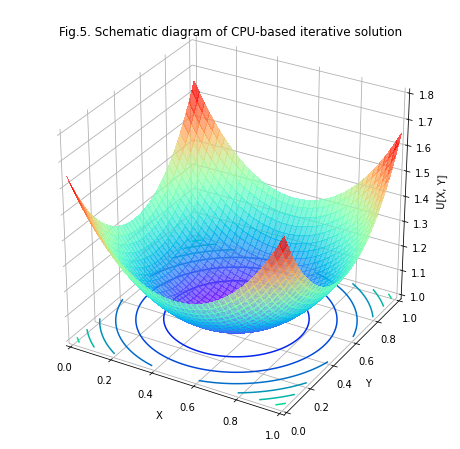

In [27]:
plot_U(X, Y, U_cpu, 'Fig.5. Schematic diagram of CPU-based iterative solution')

Observing the Figure.5, it is not difficult to find that our iterative solution method also achieves almost the same trend of change as Figure 1 and Figure 2. This proves that the method can effectively solve the discrete Poisson partial differential equation on the CPU.

### 3.2 Overview of CUDA

The CUDA programming model provides a heterogeneous environment in which host code runs programs on the CPU and the kernel runs on a physically independent GPU device. The CUDA programming model also assumes that the host and device maintain their own independent memory spaces, which are called host memory and device memory, respectively.

Since the GPU has more computing units and fewer controllers in the architecture, this means that we can perform complex logical operations on the host side, and hand over a large amount of simple data operations to the GPU for concurrent completion.

First, we need to obtain the GPU information of the device to understand whether the GPU contained in the device supports the CUDA architecture.

In [28]:
cuda.detect()

Found 1 CUDA devices
id 0    b'Tesla P100-PCIE-16GB'                              [SUPPORTED]
                      compute capability: 6.0
                           pci device id: 4
                              pci bus id: 0
Summary:
	1/1 devices are supported


True

I use Macbook Pro for development, and the programming environment is Colab. Observing the output, my device includes a GPU device that supports CUDA calculations. It is worth mentioning that the compute capability before I did not purchase Colab was 3.7, but after I purchased Colab Pro, the compute capability reached 6.0, which proves the importance of money and the preciousness of computing power.

Based on the author’s calculation ability is 6.0, it can be obtained by looking up the table. In this device, GridDim is 3, the maximum number of blocks in the x direction of Grid is 2^31-1, and the maximum number of blocks in the y and z directions is up to 65535. In addition, the maximum thread value in the x and y directions for each block has reached 1024, and the maximum thread value in the z direction has reached 64, and each block can hold up to 1024 threads.

This GPU device has considerable concurrency capabilities. Specifically, in a single dimension, the execution of the program can be executed by up to 3 ✖️(2^31-1)✖️1024 threads in parallel, which represents hundreds of billions of processes. This almost horrible amount of concurrency is far from being achieved by creating parallel threads on the CPU. This also proves the GPU's strong computing power for a large number of parallel calculations.

### 3.3 CUDA-based solution

In Section 3.1, we implemented a CPU-based iterative solution method. Next, we are ready to implement an iterative scheme on the GPU to solve the Poisson equation.

First, we need to complete the preparation of the GPU computing kernel. According to the requirements of the problem, the computing kernel will calculate one iteration of the scheme, and it needs to run multiple iterations by repeatedly calling the kernel from the host. Therefore, our discretise_gpu calculation kernel will execute the kth iteration of the K iterations, and this iteration will calculate one iteration when the matrix size is N.

In [29]:
@cuda.jit
def discretise_gpu(MaxDiff, Diff, U1, U2, f, N, k):
# Complete an iteration
  
    i, j = cuda.grid(2)

    if i >= 0 and i <= N-1 and j >= 0 and j <= N-1:
        if i > 0 and i < N-1 and j > 0 and j < N-1:
            if k%2 == 0:
                U1[i, j] =  f[i, j] / (4*((N+1)**2)) + (U2[i,j+1] + U2[i,j-1] + U2[i+1,j] + U2[i-1,j])/4 
                cuda.syncthreads()    
            else:
                U2[i, j] =  f[i, j] / (4*((N+1)**2)) + (U1[i,j+1] + U1[i,j-1] + U1[i+1,j] + U1[i-1,j])/4
                cuda.syncthreads()

            if k%100 == 0:
                Diff[i, j] = abs(U1[i, j] - U2[i, j])/abs(U2[i, j])
        else:
            if k%100 == 0:
                Diff[i, j] = abs(U1[i, j] - U2[i, j])/abs(U2[i, j])

    else:
        return

      

According to the requirements of the title, we only copy the data from the GPU device to the host at the end of the calculation, and set the initial value of U at the 0th iteration to 0 (except for the U boundary).

In addition, since each iteration requires two matrices of size N, one stores the value of the previous iteration, and the other stores the value of the current iteration. Therefore, we have opened up two global buffers U1_device and U2_device on the device side.

When the number of iterations k is even, we use U2_device to update the value of U1_device. When the number of iterations k is even, we use U1_device to update the value of U2_device. The two global buffers are updated in turn to avoid excessive demand for memory on the device side and achieve non-interference of data.


Regarding the setting of the dimensions of Block and Grid, we adopt (32, 32) and (144, 144). This is because when dividing blocks, we need to try our best to meet the maximum number of threads on each sm. In addition, the number of threads per Block is preferably a multiple of 32 or 16. This is because when SM is actually executed, the minimum operation unit warp contains 32 threads.

In [30]:
def findU_gpu(N, K):
    blockdim = (32, 32)
    griddim = (144, 144)

    Maxdifferent = np.zeros([10], dtype=np.float64)
    Diff_host = np.zeros([N,N], dtype=np.float64)

    # Transfer f and g in host to device
    f_device = cuda.to_device(f)
    g_device = cuda.to_device(g)

    # Open up two global cache spaces in the device for alternate storage of iteration results
    U1_device = cuda.device_array((N, N), dtype = np.float32)
    U2_device = cuda.device_array((N, N), dtype = np.float32)

    # Diff_device is used to store the difference between the k and k+1 generation matrices
    Diff_device = cuda.device_array((N, N), dtype = np.float32)
    

    # First assign g[i,j] to the boundary of U1 and U2, and set the inner point to 0
    for i in range(N):
        for j in range(N):
            Diff_device[i,j] = 0.0
            if i == 0 or i == N-1 or j == 0 or j == N-1:
                U1_device[i,j] = g_device[i, j]
                U2_device[i,j] = g_device[i, j]
            
            else:
                U1_device[i,j] = 0.0
                U2_device[i,j] = 0.0

    # A total of K iterations
    for k in range(K):
        discretise_gpu[griddim, blockdim](Maxdifferent, Diff_device, U1_device, U2_device, f_device, N, k)
        if k%100 == 0:
            Diff_host = Diff_device.copy_to_host()

            maxd = Diff_host.max()
            Maxdifferent[k//100] = maxd
 
    # According to the total number of iterations K, return the latest updated matrix in the device to host
    if K%2 == 1:
        U_host = U1_device.copy_to_host()
    else:
        U_host = U2_device.copy_to_host()

    return U_host, Maxdifferent

Based on the above analysis and discussion, we use the findU_gpu function to solve partial differential equations. Among them, we still set the matrix size N to 160.

In [31]:
U_host, Maxdifferent = findU_gpu(N, K)

In order to express the three-dimensional image of U more clearly and intuitively, we used the plot_U function to draw the numerical solution copied from the device end back to the host end, as shown in the Figure.6.

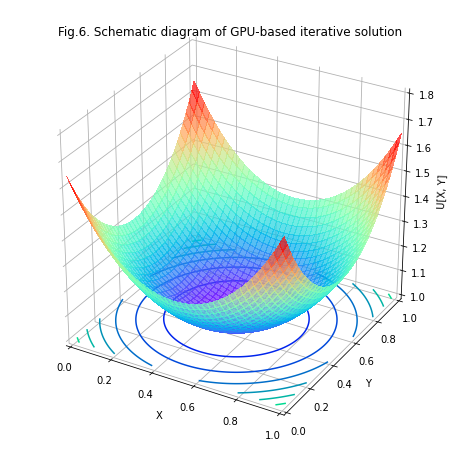

In [32]:
plot_U(X, Y, U_host, 'Fig.6. Schematic diagram of GPU-based iterative solution')

Observing Figure 6 shows that the three-dimensional trend of U_host in unit square is almost the same as that in Figures 1, 2 and 4, which proves that the iterative solution method in GPU is also effective for the numerical solution of partial differential equations. Approaching.

### 3.4 Convergence between iterations from kth to k+1th

In order to discuss the convergence of the GPU iterative solution method as the iteration grows, we calculate the maximum relative change between iterations to evaluate the accuracy of GPU concurrent programs.

Since each check for convergence between iterations requires access to the host, which will cause a lot of time-consuming, it is impossible for us to check convergence for every iteration. Therefore, in 1000 iterations, we selected 10 iterations with an interval of 100.

In [33]:
U_host1, Maxdifferent1 = findU_gpu(16, K)
U_host2, Maxdifferent2 = findU_gpu(32, K)
U_host3, Maxdifferent3 = findU_gpu(64, K)
U_host3, Maxdifferent4 = findU_gpu(96, K)

In order to explore the accuracy of different sizes of matrices in the iteration, we selected the matrix size N to be 16, 32, 64, 128, for each of them, selected 10 iterations from 0 to 1000, and performed the image Draw as shown.

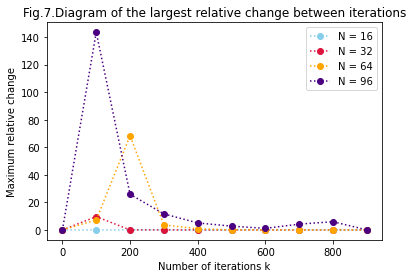

In [34]:
plt.plot(range(0,1000,100), Maxdifferent1,':',label = 'N = 16',color='skyblue', marker = 'o')
plt.plot(range(0,1000,100), Maxdifferent2,':',label = 'N = 32',color='crimson', marker = 'o')
plt.plot(range(0,1000,100), Maxdifferent3,':',label = 'N = 64',color='orange', marker = 'o')
plt.plot(range(0,1000,100), Maxdifferent4,':',label = 'N = 96',color='indigo', marker = 'o')

plt.xlabel('Number of iterations k')
plt.ylabel('Maximum relative change')
plt.title('Fig.7.Diagram of the largest relative change between iterations')
plt.legend()
plt.show()

Observing the graph, we can see that as the number of iterations k increases, the maximum relative changes of the four matrices with different dimensions all show the nature of convergence.

For example, when the matrix dimension N=64, although the error is extremely large when the number of iterations is 200, about 70, as the iteration progresses, the curve of the maximum relative change shows a downward trend, which represents the U matrix As the iteration progresses, the value of U continues to approach the theoretical value, and there is less and less space for change, which reflects the convergence.

In addition, the larger the matrix dimension N is, the more iterations are needed to show convergence. For example, comparing N=128 and N=16 in the figure, it is not difficult to find that the large matrix with N=128 takes more iterations than the small matrix with N=16 to converge to the theoretical solution, and its maximum relative The error is also larger than the small matrix.

In short, when it comes to solving on the GPU, as the iteration progresses, the solution shows convergence, but its optimization space is limited. The reason is that in the GPU, the data type is single-precision, which means that when the data is transmitted from the host side to the device side, the data accuracy may be reduced. Due to the reduced accuracy, when iterating, the variation space between generations is very low, which also means that the error will be reduced very slowly.

### 3.5 GPU benchmark

In order to explore the computing performance of GPUs, we benchmarked GPU-based iterative algorithms. Among them, we selected four matrices with matrix dimensions from 16 to 65 to perform benchmark tests on CPU-based and GPU-based iterative algorithms to compare the performance of the two.

In [ ]:
timeit_result2 = np.zeros(4, dtype=np.float64)
timeit_result3 = np.zeros(4, dtype=np.float64)
for loop in range(16,65,16):
    print(loop)
    timeit_result_2 = %timeit -o findU_gpu(loop, K)
    timeit_result_3 = %timeit -o discretise_cpu(f, g, loop, K)
    timeit_result2[int(loop//16)-1] = timeit_result_2.best
    timeit_result3[int(loop//16)-1] = timeit_result_3.best

In order to show the comparison of its computational performance more intuitively, we have also drawn the time-consuming schematic diagram of iterative algorithms based on CPU and GPU, as shown in Figure 8.

[1.62397515 3.29793038 6.07103234 9.93920265]


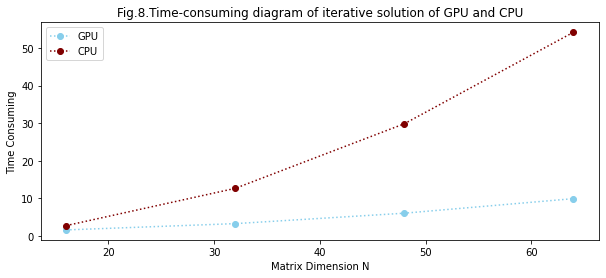

In [49]:
print(timeit_result2)
x_fit = range(16, 65, 16)

plt.figure(figsize=(10,4))
plt.plot(x_fit,timeit_result2, ':',label = 'GPU',color='skyblue', marker = 'o')
plt.plot(x_fit,timeit_result3, ':',label = 'CPU',color='maroon', marker = 'o')
plt.xlabel('Matrix Dimension N')
plt.ylabel('Time Consuming')
plt.title('Fig.8.Time-consuming diagram of iterative solution of GPU and CPU')
plt.legend()
plt.show()

It is not difficult to find from Figure 8 that the GPU has better computing performance. For example, for a matrix with a matrix size N of 64, the time required for the GPU to complete 1000 iterations is 9.94 seconds, which is much lower than the 54.2 seconds required for the CPU to complete 1000 iterations. This proves that GPU has better computing performance.

The performance difference between the two when iteratively solves partial differential equations can be analyzed through the design of the underlying architecture of the CPU and GPU. The CPU needs strong versatility to handle various data types, and at the same time it requires logical judgment and introduces a large number of branch jumps and interrupt processing. All these make the internal structure of the CPU extremely complicated. The CPU not only takes up a lot of space by the Cache, but also has complex control logic and many optimization circuits. In contrast, the computing power is only a small part of the CPU.

The GPU is faced with a highly unified, independent, large-scale data and a pure computing environment that does not need to be interrupted. Therefore, GPU uses a large number of computing units and long pipelines, but only has very simple control logic and saves Cache.

In each iteration, the operations performed by the interior points are not logically related to each other, so these operations can be performed in parallel. Therefore, in this case, the GPU can show better computing performance than the CPU.

### 3.6 GPU convergence analysis
Similar to the CPU convergence analysis in Section 2.4, in order to verify the convergence and parallel computing capabilities of the GPU-based CUDA iterative solution method, we calculated the numerical solution based on this method and compared it with the exact discrete solution.

Specifically, first, we set the number of iterations to 1000, and selected five values between 32 and 160 for the matrix dimension N.

For each matrix of size N, we use the CUDA iterative solution method to calculate it, and also calculate the theoretical solution of the corresponding dimension. In order to reflect the difference between the numerical solution and the theoretical solution, we adopted the concept of the maximum relative error, respectively calculated and plotted the curve of the increase of the maximum relative error with the increase of N.

In [ ]:
maxerels_gpu = np.empty(5, dtype=np.float64)
count_gpu = 0
for n in range(32,161,32):
    U_gpu, maxdiff = findU_gpu(n, 1000)
    U_cpu, g_cpu = findU(n)
    maxeral_gpu = 0
    for i in range(n):
        for j in range(n):
            eral_gpu = abs(U_gpu[i,j] - g_cpu[i,j])/abs(g_cpu[i,j])
            if eral_gpu > maxeral_gpu:
                maxeral_gpu = eral_gpu
            else:
                continue
    maxerels_gpu[count_gpu] = maxeral_gpu
    count_gpu += 1

No handles with labels found to put in legend.


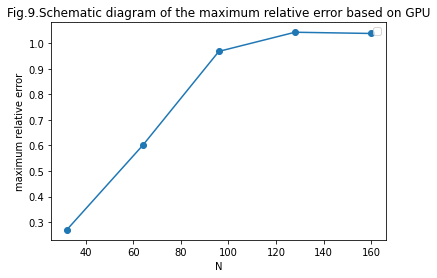

In [50]:
plt.plot(range(32,161,32),maxerels_gpu,marker = 'o')
plt.xlabel('N')
plt.ylabel('maximum relative error')
plt.title('Fig.9.Schematic diagram of the maximum relative error based on GPU')
plt.legend()
plt.show()  

Observing the graph 9, we can see that for a certain number of iterations, when the matrix dimension N increases, the convergence of the CUDA-based iterative solution method seems to deteriorate.

For example, when the matrix size is 32, the maximum relative error is only 0.26941642. When the matrix dimension N increases to 128, the maximum relative error increases to 1.04297533. This means that as the dimension of the matrix increases, the number of iterations required to achieve convergence increases. In more depth, larger matrices require more iterations to reflect better convergence.

In addition, with regard to the convergence speed, it is not difficult to observe the image and find that the number of iterations that can achieve convergence is different for different matrix sizes. Since the data accuracy is reduced when the data is transmitted from the host side to the device side, this results in a small space for variation between generations, which also means that the error will be reduced very slowly. In general, the convergence speed of the iterative solution based on GPU is slower than that of the CPU.

### 3.7 Optimize memory access

In this section, we use the shared memory method to optimize memory access. In Section 3.3, we opened up two global buffers, and each calculation involves multiple reads and writes of data in the global buffer. Therefore, we use a method of preloading value blocks into local shared memory to optimize memory access.

### 3.8 Summary

Generally speaking, for the discrete Poisson problem on the unit square, GPU shows excellent iterative computing performance and weak convergence performance.

First of all, due to the underlying architecture design suitable for high-concurrency scenarios, GPUs consume less time than CPUs when processing high-concurrency computing programs, reflecting better computing capabilities. However, due to the difference between the type of data stored in the GPU and the CPU, the loss of precision will cause the GPU to limit the amount of change between generations and the final convergence performance during iterative calculations, showing a slower convergence speed than the CPU.

## Conclusion



In general, in this assignment, based on the CPU and GPU, we performed a numerical solution to the partial differential equation in unit square. Specifically, the CPU-based interior point calculation method achieves better convergence performance, but it consumes too much time, while the iterative method based on CUDA for GPU calculation achieves better parallel computing performance, but the convergence speed is limited.

The performance difference between GPU and CPU is determined by their underlying architecture and applicable scenarios. The performance of the CPU is reflected in low latency, and the performance of the GPU is reflected in high throughput. The GPU is to delete the parts of the CPU that make various preparations for the ALU and reduce the ALU delay, and greatly increase the number of ALUs and general-purpose registers, and hide the delay of the task by switching between parallel tasks. Since the GPU does not care about the stagnation of a single task, the key to GPU optimization is to allow all functional units to have a new task input every cycle, so that peak performance can be achieved.

Due to lack of time, there is a lot of room for improvement in this job. For example, the coo matrix in Section 2.1 can be stored in the form of csr for further optimization, and the memory optimization in 3.7 can be achieved by sharing memory to achieve optimal performance, and so on. 

Therefore, in the future, the optimization of GPU computing performance based on the CUDA architecture can be further developed through the following points.

* Reasonably select the part that needs performance optimization. Estimate the performance bottleneck according to the performance model of the operating environment and make corresponding adjustments.

* Limit and sort out the input requirements. For example, by adding a higher-level external interface, plus pre-screening, tasks that meet this part of the demand can be imported into this branch, and other tasks can be imported into another general but worse-performance branch. Then, make the most frequently used branches fast, make the less frequently used branches right, and choose a reasonable balance between workload and overall performance improvement, which is also a balance between versatility and performance.

* Streamline the algorithm complexity and calculation amount. Compared with serial algorithms, parallel algorithms may have many calculation paths that are completely consistent between each computing thread. However, due to the relatively high cost of synchronization and communication, there will inevitably be some redundant calculations. During implementation, redundant calculations should be removed as much as possible to reduce waste of computing resources.



## Reference

* Nickolls J R ,  Buck I ,  Garland M , et al. Scalable parallel programming with CUDA[C]// Hot Chips 20 Symposium. ACMPUB27New York, NY, USA, 2008.
* Shuai C ,  Boyer M ,  Meng J , et al. A performance study of general-purpose applications on graphics processors using CUDA[J]. Journal of Parallel & Distributed Computing, 2008, 68(10):1370-1380.
*Garland, Michael, Le, et al. PARALLEL COMPUTING EXPERIENCES WITH CUDA.[J]. IEEE Micro, 2008.
*Vineet V ,  Narayanan P J . CUDA cuts: Fast graph cuts on the GPU[C]// IEEE Computer Society Conference on Computer Vision & Pattern Recognition Workshops. IEEE, 2008.
* Ueng S Z ,  Lathara M ,  Baghsorkhi S S , et al. CUDA-Lite: Reducing GPU Programming Complexity.[J]. Lecture Notes in Computer Science, 2008, 5335:1-15.
*Yuancheng. Canny edge detection on NVIDIA CUDA[C]// Radar Conference, 2005, IEEE International. IEEE, 2008.
*Pospichal P ,  Jaros J ,  Schwarz J . Parallel Genetic Algorithm on the CUDA Architecture[C]// Applications of Evolutionary Computation, Evoapplicatons: Evocomplex, Evogames, Evoiasp, Evointelligence, Evonum, & Evostoc, Istanbul, Turkey, April. DBLP, 2010.
*Weickert J ,  Schnrr C . A Theoretical Framework for Convex Regularizers in PDE-Based Computation of Image Motion[J]. International Journal of Computer Vision, 2001, 45(3):245-264.
*Pierce, Niles, A, et al. Adjoint Recovery of Superconvergent Functionals from PDE Approximations.[J]. Siam Review, 2000.
*Hui L ,  Yu S ,  Chen Z , et al. Sparse matrix-vector multiplication on NVIDIA GPU.[J]. Int.j.numer.anal.model.ser.b, 2012.
*Choquette J ,  Gandhi W ,  Giroux O , et al. NVIDIA A100 Tensor Core GPU: Performance and Innovation[J]. IEEE Micro, 2021, PP(99):1-1.
*Ko C J ,  Chen P C ,  Wong H K , et al. MoSES_2PDF: A GIS-Compatible GPU-accelerated High-Performance Simulation Tool for Grain-Fluid Shallow Flows[J].  2021.